# dQA perceptron hamiltonian circuit tests

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# useful definitions

def qft_dagger(qc, n, shift = 0):
    """n-qubit QFTdagger on n qubits in circ, shifting by arg value"""
    for qubit in range(n//2):
        qc.swap(shift+qubit, shift+n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), shift+m, shift+j)
        qc.h(shift+j)

## small scale test

This circuit will count how many ones we have in data qubits.

In [3]:
def circuit_counter(data_qubits : int, ancillary_qubits, qc = None, flips = None, theta = None):
    """counts how many ones are there in data_qubits"""

    if qc is None:
        qc = QuantumCircuit(data_qubits + ancillary_qubits, ancillary_qubits)

    # initialize the circuit
    if flips is not None:
        for ii in range(flips):
            qc.x(ii)

    if theta is None:
        theta = math.pi/(2**(ancillary_qubits-1))

    # prepare ancillary qubits with Hadamard gate
    for ii in range(ancillary_qubits):
        qc.h(data_qubits + ii)

    # linking the phase shifts in Fourier basis
    for target_qubit in range(data_qubits):  #ancillary_qubits
        repetitions = 1
        for counting_qubit in range(ancillary_qubits):
            #for _ in range(repetitions):
            #    qc.cp(theta, data_qubits + counting_qubit, target_qubit)
            qc.cp(theta*repetitions, data_qubits + counting_qubit, target_qubit)

            repetitions *= 2

    # add QFT
    qc.barrier()
    qft_dagger(qc, ancillary_qubits, shift = data_qubits)
    qc.barrier()

    # measure ancillaries
    for ii in range(ancillary_qubits):
        qc.measure(ii+data_qubits,ii)
    
    return qc

In [4]:
qq = circuit_counter(4, 3, flips = 3, theta = None)
# remark:  ancillaries must be  floor( log2(n) ) + 1
qq.draw()

┌───┐                                                                    »
q_0: ┤ X ├─■────────■─────────────────■───────────────────────────────────────»
     ├───┤ │        │                 │                                       »
q_1: ┤ X ├─┼────────┼────────■────────┼──────■─────────────────■──────────────»
     ├───┤ │        │        │        │      │                 │              »
q_2: ┤ X ├─┼────────┼────────┼────────┼──────┼────────■────────┼──────■───────»
     └───┘ │        │        │        │      │        │        │      │       »
q_3: ──────┼────────┼────────┼────────┼──────┼────────┼────────┼──────┼───────»
     ┌───┐ │P(π/4)  │        │P(π/4)  │      │        │P(π/4)  │      │       »
q_4: ┤ H ├─■────────┼────────■────────┼──────┼────────■────────┼──────┼───────»
     ├───┤          │P(π/2)           │      │P(π/2)           │      │P(π/2) »
q_5: ┤ H ├──────────■─────────────────┼──────■─────────────────┼──────■───────»
     ├───┤                            │P(π)                    │P(π)          »
q_6: ┤ H ├────────────────────────────■────────────────────────■──────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                      ░                                  »
«q_0: ─────────────────────────────────░──────────────────────────────────»
«                                      ░                                  »
«q_1: ─────────────────────────────────░──────────────────────────────────»
«                                      ░                                  »
«q_2: ──────────■──────────────────────░──────────────────────────────────»
«               │                      ░                                  »
«q_3: ─■────────┼──────■────────■──────░──────────────────────────────────»
«      │P(π/4)  │      │        │      ░    ┌───┐                         »
«q_4: ─■────────┼──────┼────────┼──────░──X─┤ H ├─■──────────────■────────»
«               │      │P(π/2)  │      ░  │ └───┘ │P(-π/2) ┌───┐ │        »
«q_5: ──────────┼──────■────────┼──────░──┼───────■────────┤ H ├─┼────────»
«               │P(π)           │P(π)  ░  │                └───┘ │P(-π/4) »
«q_6: ──────────■───────────────■──────░──X──────────────────────■────────»
«                                      ░                                  »
«c: 3/════════════════════════════════════════════════════════════════════»
«                                                                         »
«                     ░          
«q_0: ────────────────░──────────
«                     ░          
«q_1: ────────────────░──────────
«                     ░          
«q_2: ────────────────░──────────
«                     ░          
«q_3: ────────────────░──────────
«                     ░ ┌─┐      
«q_4: ────────────────░─┤M├──────
«                     ░ └╥┘┌─┐   
«q_5: ─■──────────────░──╫─┤M├───
«      │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_6: ─■────────┤ H ├─░──╫──╫─┤M├
«               └───┘ ░  ║  ║ └╥┘
«c: 3/═══════════════════╩══╩══╩═
«                        0  1  2

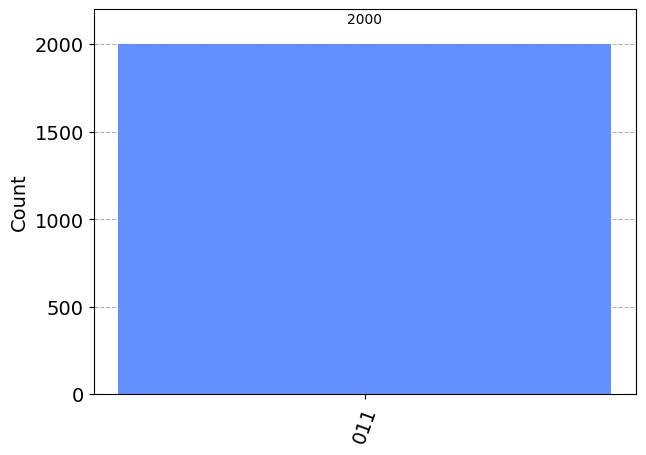

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(transpile(qq, aer_sim), shots=2000)
answer = aer_sim.run(qobj).result().get_counts()
plot_histogram(answer)

<br><br>

## full demo

In [6]:
def circuit_heaviside(data_qubits : int, # how many quibits are used for data encoding
                      data : np.array,   # the data array (of values +-1)
                      init_flips = None, # if qc is None, initialize the circuit with this flips
                      ancillary_qubits = None, # how many ancillaries to use, if None it is automatically computed
                      theta = None, # rotation to use in qubit (automatic is better)
                      qc = None):   # if None, init a new circuit
    
    assert len(data) == data_qubits

    # compute the number of ancillaries and optimal rotation value
    if ancillary_qubits is None:
        ancillary_qubits = int( np.ceil( np.log2(data_qubits) ) + 1 )
        print('using {} ancillaries'.format(ancillary_qubits) )
    if theta is None:
        theta = math.pi/(2**(ancillary_qubits-1))

    # create a new circuit if not prompted as arg
    if qc is None:
        qc = QuantumCircuit(data_qubits + ancillary_qubits, ancillary_qubits)

        # init the qubits
        if init_flips is not None:
            assert len(init_flips) == data_qubits

            for ii, qb in enumerate(init_flips):
                if qb == +1:  qc.x(ii)
        
        print("expecting {} wrong spins".format(data_qubits - np.count_nonzero(init_flips==data)) )
        qc.barrier()


    # rotate data qubits if the data feature is one (will be reverted later)
    for ii, qb in enumerate(data):
        if qb == +1:  qc.x(ii)

    # prepare ancillary qubits with Hadamard gate
    for ii in range(ancillary_qubits):
        qc.h(data_qubits + ii)

    # linking the phase shifts in Fourier basis
    for target_qubit in range(data_qubits):  #ancillary_qubits
        repetitions = 1
        for counting_qubit in range(ancillary_qubits):
            #for _ in range(repetitions):
            #    qc.cp(theta, data_qubits + counting_qubit, target_qubit)
            qc.cp(theta*repetitions, data_qubits + counting_qubit, target_qubit)

            repetitions *= 2

    # apply QFT inverse
    qc.barrier()
    qft_dagger(qc, ancillary_qubits, shift = data_qubits)
    qc.barrier()

    # revert rotation of data qubits
    for ii, qb in enumerate(data):
        if qb == +1:  qc.x(ii)

    # trick: cnot the last ancillary with previous one to evaluate if > N/2
    qc.cx(data_qubits+ancillary_qubits-2, data_qubits+ancillary_qubits-1)

    # measure ancillaries
    for ii in range(ancillary_qubits):
        qc.measure(ii+data_qubits,ii)
    
    return qc

using 3 ancillaries
expecting 2 wrong spins


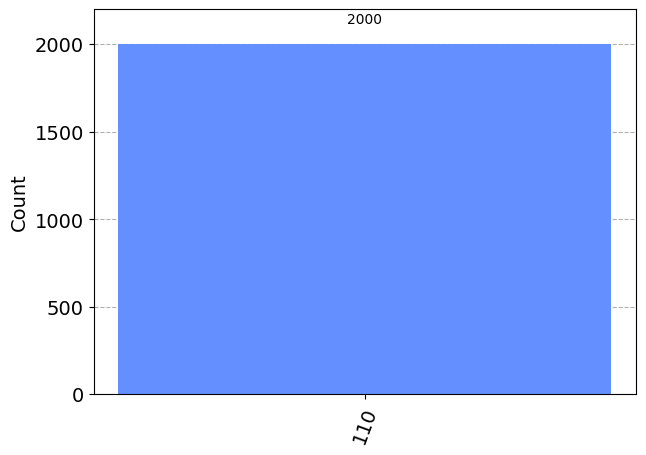

In [18]:
qq = circuit_heaviside( data_qubits = 4,
    data = np.array([1,0,0,0]),        # qubits of our data
    init_flips= np.array([1,0,1,1]) )  # initial qubits of

#   ancillaries must be  floor( log2(n) ) + 1
#qq.draw()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(transpile(qq, aer_sim), shots=2000)
answer = aer_sim.run(qobj).result().get_counts()
plot_histogram(answer)

In [19]:
data = [1,0,0,0]
init_flips= [0,1,1,1]


using 5 ancillaries
expecting 7 wrong spins


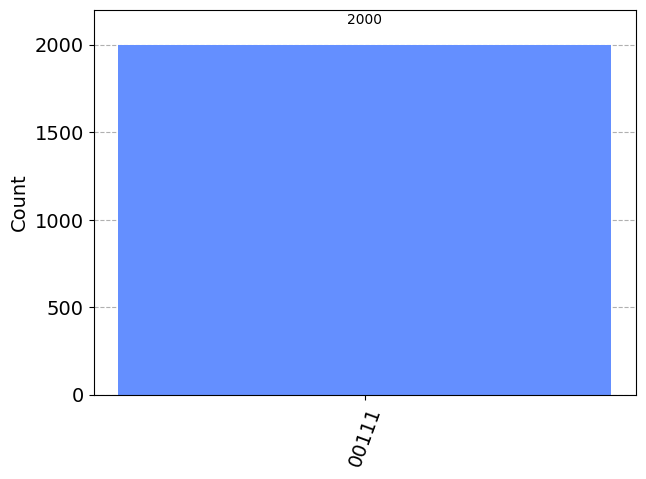

In [20]:
qq = circuit_heaviside( data_qubits = 16,
    data =       np.array([1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1]),
    init_flips = np.array([1,0,0,1,1,1,0,1,0,0,1,0,1,1,1,1])
)

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(transpile(qq, aer_sim), shots=2000)
answer = aer_sim.run(qobj).result().get_counts()
plot_histogram(answer)

using 5 ancillaries
expecting 8 wrong spins


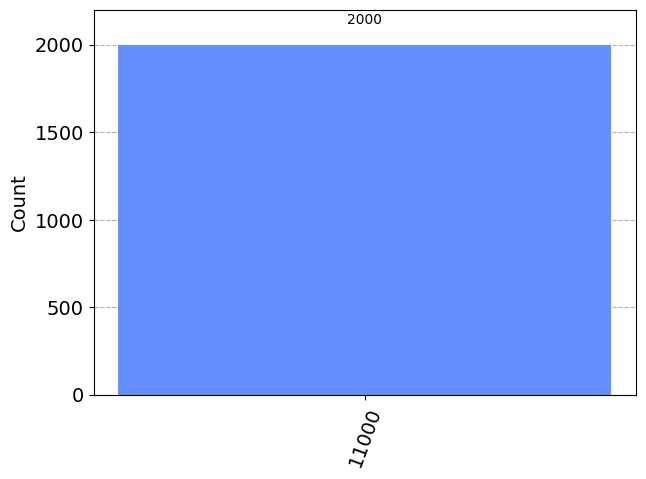

In [21]:
qq = circuit_heaviside( data_qubits = 16,
    data =       np.array([1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,1]),
    init_flips = np.array([1,0,0,1,1,1,0,1,0,0,1,0,1,1,1,1])
)

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(transpile(qq, aer_sim), shots=2000)
answer = aer_sim.run(qobj).result().get_counts()
plot_histogram(answer)

using 5 ancillaries
expecting 16 wrong spins


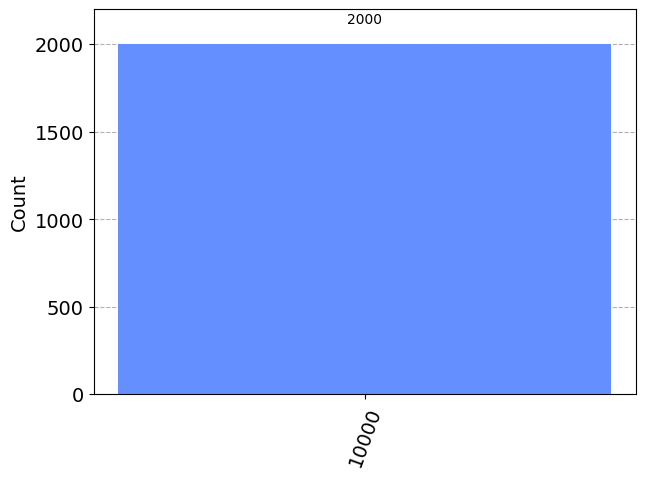

In [22]:
qq = circuit_heaviside( data_qubits = 16,
    data =       np.array([1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1]),
    init_flips = np.array([0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0])
)

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(transpile(qq, aer_sim), shots=2000)
answer = aer_sim.run(qobj).result().get_counts()
plot_histogram(answer)